--- LANGKAH 1: MEMBUAT DATA DUMMY ---
Contoh Data Mentah (5 Teratas):
                    Nama    Tanggal  Menit_Kedatangan Jam_Datang_Format
0          Budi (Stabil) 2025-01-01        457.008058             07:37
1  Siti (Gejala Burnout) 2025-01-01        477.100498             07:57
2          Budi (Stabil) 2025-01-02        471.141595             07:51
3  Siti (Gejala Burnout) 2025-01-02        474.603944             07:54
4          Budi (Stabil) 2025-01-03        466.173666             07:46


--- LANGKAH 2: FEATURE ENGINEERING ---
Data Siap Masuk ML (Perhatikan kolom 'Volatilitas_5Hari'):
                     Nama    Tanggal Jam_Datang_Format  Volatilitas_5Hari
48          Budi (Stabil) 2025-02-04             07:49           4.987546
49  Siti (Gejala Burnout) 2025-02-04             08:01           2.950754
50          Budi (Stabil) 2025-02-05             07:46           4.855258
51  Siti (Gejala Burnout) 2025-02-05             07:59           2.844727
52          Budi (Stabil) 20

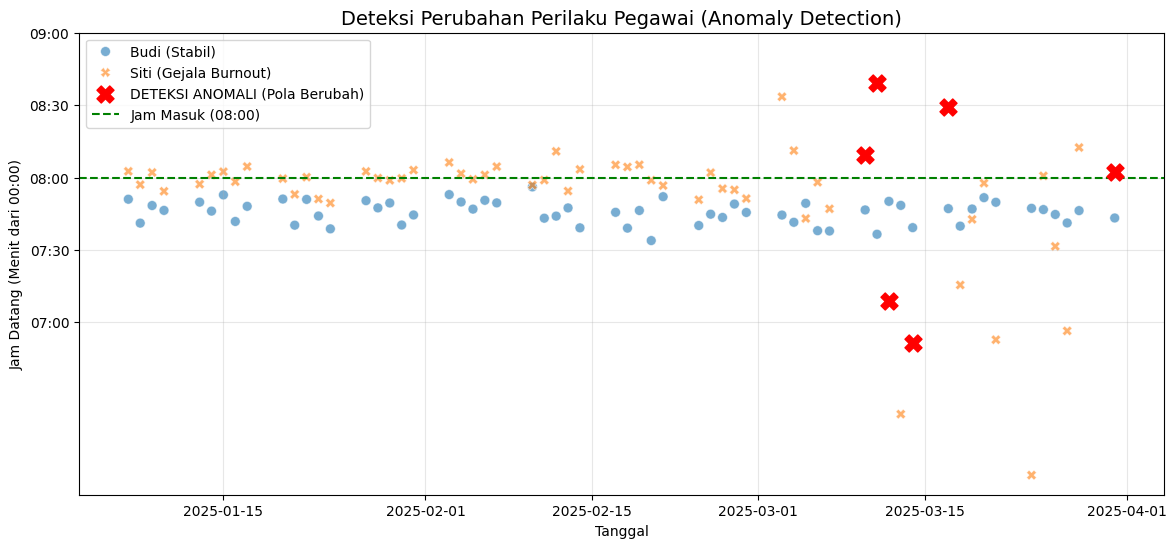

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from datetime import datetime, timedelta

# ==========================================
# BAGIAN 1: MEMBUAT DATA DUMMY (Skenario)
# ==========================================
print("--- LANGKAH 1: MEMBUAT DATA DUMMY ---")

def generate_dummy_data():
    # Kita buat data 3 bulan (Jan - Maret 2025)
    dates = pd.date_range(start='2025-01-01', end='2025-03-31', freq='B') # Business Days (Senin-Jumat)
    data = []

    for date in dates:
        # --- PEGAWAI 1: BUDI (Si Stabil) ---
        # Budi selalu datang sekitar jam 07:45 dengan variasi sangat kecil (+/- 5 menit)
        noise_budi = np.random.normal(0, 5)
        arrival_budi = 7.75 * 60 + noise_budi # 7.75 jam = 07:45
        data.append(['Budi (Stabil)', date, arrival_budi])

        # --- PEGAWAI 2: SITI (Si Burnout / Galau) ---
        # Bulan 1 & 2: Siti masih stabil (datang jam 08:00)
        if date.month < 3:
            noise_siti = np.random.normal(0, 5)
            arrival_siti = 8.0 * 60 + noise_siti # Jam 08:00
        else:
            # Bulan 3: Siti mulai kena mental (Burnout).
            # Polanya kacau: Kadang kepagian banget (07:30), kadang mepet banget (08:30)
            # Variansinya kita naikkan jadi +/- 45 menit!
            noise_siti = np.random.normal(0, 45)
            arrival_siti = 8.0 * 60 + noise_siti

        data.append(['Siti (Gejala Burnout)', date, arrival_siti])

    return pd.DataFrame(data, columns=['Nama', 'Tanggal', 'Menit_Kedatangan'])

df = generate_dummy_data()

# Konversi Menit ke Jam (biar enak dilihat manusia di tabel)
df['Jam_Datang_Format'] = df['Menit_Kedatangan'].apply(lambda x: f"{int(x//60):02d}:{int(x%60):02d}")

print("Contoh Data Mentah (5 Teratas):")
print(df.head())
print("\n")

In [ ]:
# ==========================================
# BAGIAN 2: FEATURE ENGINEERING (Otak-Atik Data)
# ==========================================
print("--- LANGKAH 2: FEATURE ENGINEERING ---")
# Disini kita ubah data 'Jam' menjadi data 'Pola/Konsistensi'

# Kita hitung Rolling Standard Deviation (Standar Deviasi Bergerak) per 5 hari
# Artinya: Seberapa "goyah" jam datang dia dalam seminggu terakhir?
df['Volatilitas_5Hari'] = df.groupby('Nama')['Menit_Kedatangan'].transform(lambda x: x.rolling(window=5).std())

# Hapus data NaN (5 hari pertama pasti kosong karena belum cukup data buat rolling)
df_clean = df.dropna().copy()

print("Data Siap Masuk ML (Perhatikan kolom 'Volatilitas_5Hari'):")
print(df_clean[['Nama', 'Tanggal', 'Jam_Datang_Format', 'Volatilitas_5Hari']].iloc[40:45]) # Ambil sampel tengah
print("\n")

In [ ]:
# ==========================================
# BAGIAN 3: MACHINE LEARNING (Isolation Forest)
# ==========================================
print("--- LANGKAH 3: TRAINING MODEL ---")

# Kita pakai 'Volatilitas' sebagai fitur utama untuk deteksi anomali
X = df_clean[['Volatilitas_5Hari']]

# Panggil Model Isolation Forest
# contamination=0.05 artinya kita estimasi 5% data adalah anomali
model = IsolationForest(contamination=0.05, random_state=42)

# Latih Model
model.fit(X)

# Prediksi (-1 = Anomali, 1 = Normal)
df_clean['Anomaly_Score'] = model.predict(X)

# Beri label biar mudah dibaca
df_clean['Status'] = df_clean['Anomaly_Score'].apply(lambda x: '⚠️ ANOMALI' if x == -1 else 'Normal')

# Cek siapa saja yang kena deteksi
anomalies = df_clean[df_clean['Status'] == '⚠️ ANOMALI']
print(f"Ditemukan {len(anomalies)} data anomali.")
print("Contoh Data Anomali (Perhatikan Volatilitas-nya tinggi):")
print(anomalies[['Tanggal', 'Nama', 'Jam_Datang_Format', 'Volatilitas_5Hari']].head())

In [ ]:
# ==========================================
# BAGIAN 4: VISUALISASI (Dashboard)
# ==========================================
print("\n--- LANGKAH 4: VISUALISASI HASIL ---")

plt.figure(figsize=(14, 6))

# 1. Plot Titik Normal (Warna Biru & Oranye per orang)
sns.scatterplot(data=df_clean[df_clean['Status'] == 'Normal'],
                x='Tanggal', y='Menit_Kedatangan', hue='Nama', style='Nama', s=50, alpha=0.6)

# 2. Plot Titik Anomali (Warna Merah Besar)
# Kita filter cuma ambil yang anomali
data_anomali = df_clean[df_clean['Status'] == '⚠️ ANOMALI']
plt.scatter(data_anomali['Tanggal'], data_anomali['Menit_Kedatangan'],
            color='red', s=150, label='DETEKSI ANOMALI (Pola Berubah)', zorder=10, marker='X')

# Hiasan Grafik
plt.axhline(y=8*60, color='green', linestyle='--', label='Jam Masuk (08:00)') # Garis jam 8
plt.title('Deteksi Perubahan Perilaku Pegawai (Anomaly Detection)', fontsize=14)
plt.ylabel('Jam Datang (Menit dari 00:00)')
plt.xlabel('Tanggal')

# Ubah label Y axis biar jadi jam (bukan menit)
yticks = [420, 450, 480, 510, 540] # 07:00 - 09:00
ytick_labels = ['07:00', '07:30', '08:00', '08:30', '09:00']
plt.yticks(yticks, ytick_labels)

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()